In [1]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import rotate, shift, zoom
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedgamal07/reduced-mnist")

print("Path to dataset files:", path)

100%|██████████| 9.62M/9.62M [00:00<00:00, 54.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohamedgamal07/reduced-mnist/versions/1


In [3]:
# --------------------------
# Data Loading Functions
# --------------------------
def load_data(train_dir, test_dir):
    """Load MNIST data from directories"""
    # Load training data
    images, labels = [], []
    for label in sorted(os.listdir(train_dir)):
        label_dir = os.path.join(train_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                with Image.open(img_path) as img:
                    img_array = np.array(img.convert('L'), dtype=np.float32) / 255.0
                    images.append(img_array)
                    labels.append(int(label))

    # Load test data
    test_images, test_labels = [], []
    for label in sorted(os.listdir(test_dir)):
        label_dir = os.path.join(test_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                with Image.open(img_path) as img:
                    img_array = np.array(img.convert('L'), dtype=np.float32) / 255.0
                    test_images.append(img_array)
                    test_labels.append(int(label))

    return (
        np.array(images), np.array(labels),
        np.array(test_images), np.array(test_labels)
)

In [4]:
# --------------------------
# Data Preparation Functions
# --------------------------
def create_subset(images, labels, n_per_class=40):
    """Create balanced subset with n_per_class samples per class"""
    subset_images, subset_labels = [], []
    for class_label in range(10):
        class_indices = np.where(labels == class_label)[0]
        selected = np.random.choice(class_indices, n_per_class, replace=False)
        subset_images.extend(images[selected])
        subset_labels.extend(labels[selected])
    return (
        np.array(subset_images),
        np.array(subset_labels),
        np.concatenate([np.where(labels == c)[0][:n_per_class] for c in range(10)])
    )


In [5]:
def get_uncertain_samples(model, X_unlabeled, n_samples=100):
    # Flatten images for SVM
    X_flat = X_unlabeled.reshape(X_unlabeled.shape[0], -1)
    decision_values = model.decision_function(X_flat)
    margins = np.sort(decision_values, axis=1)[:, -1] - np.sort(decision_values, axis=1)[:, -2]  # Margin between top 2 classes
    uncertain_indices = np.argsort(margins)[:n_samples]  # Smallest margins = most uncertain
    return uncertain_indices

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import copy

def active_learning_loop(X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test,
                         n_iterations=10, samples_per_iteration=100,
                         patience=8, tol=0.001):
    """
    Active learning pipeline with uncertainty sampling and early stopping.
    Evaluation is performed on the test set.

    Returns:
    model: Trained SVM model
    X_labeled, y_labeled: Updated labeled dataset
    X_unlabeled, y_unlabeled: Remaining unlabeled pool
    accuracies: List of test accuracies per iteration
    pipeline_human_time_list: List of cumulative labeling time (in seconds) after each iteration
    full_manual_time: Estimated labeling time (in seconds) if all images were manually labeled
    stopped_early: Boolean indicating if early stopping was triggered
    """
    # Flatten initial labeled data and test set
    X_labeled_flat = X_labeled.reshape(X_labeled.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Initialize SVM model with probability enabled (if needed by uncertainty sampling)
    model = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)

    # Track metrics
    accuracies = []

    # Calculate full manual labeling time based on the entire training dataset at the start.
    original_total = len(y_labeled) + len(y_unlabeled)
    full_manual_time = original_total * 10  # seconds (10 seconds per image)

    # Pipeline human time starts with the time to label the initial labeled set.
    pipeline_human_time = len(y_labeled) * 10  # seconds
    pipeline_human_time_list = [pipeline_human_time]

    best_acc = 0.0
    wait = 0
    stopped_early = False

    for i in range(n_iterations):
        # Train on current labeled data
        model.fit(X_labeled_flat, y_labeled)
        # Evaluate on the test set for early stopping
        test_preds = model.predict(X_test_flat)
        acc = accuracy_score(y_test, test_preds)
        accuracies.append(acc)

        print(f"Iteration {i+1}/{n_iterations} | Test Accuracy: {acc:.3f} | Best: {best_acc:.3f} | Wait: {wait}/{patience}")

        # Early stopping check based on test set accuracy
        if acc > best_acc + tol:
            best_acc = acc
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f"\nEarly stopping triggered at iteration {i+1}")
            stopped_early = True
            break

        # Sample selection: uncertainty sampling function assumed defined as get_uncertain_samples
        uncertain_indices = get_uncertain_samples(model, X_unlabeled, samples_per_iteration)
        if len(uncertain_indices) == 0:
            print("No uncertain samples selected.")
            break

        X_new = X_unlabeled[uncertain_indices]
        y_new = y_unlabeled[uncertain_indices]

        # Update labeled and unlabeled datasets
        X_labeled = np.concatenate([X_labeled, X_new])
        y_labeled = np.concatenate([y_labeled, y_new])
        X_labeled_flat = X_labeled.reshape(X_labeled.shape[0], -1)

        X_unlabeled = np.delete(X_unlabeled, uncertain_indices, axis=0)
        y_unlabeled = np.delete(y_unlabeled, uncertain_indices, axis=0)

        # Increase pipeline human time by the actual number of newly selected samples (10 sec each)
        pipeline_human_time += len(uncertain_indices) * 10
        pipeline_human_time_list.append(pipeline_human_time)

    print(f"\nFull manual labeling time (for {original_total} images): {full_manual_time} seconds")
    print(f"Pipeline human labeling time list: {pipeline_human_time_list}")

    return model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, accuracies, pipeline_human_time_list, full_manual_time, stopped_early


In [11]:
train_dir = "/root/.cache/kagglehub/datasets/mohamedgamal07/reduced-mnist/versions/1/Reduced MNIST Data/Reduced Trainging data"
test_dir = "/root/.cache/kagglehub/datasets/mohamedgamal07/reduced-mnist/versions/1/Reduced MNIST Data/Reduced Testing data"
X_train_full, y_train_full,x_test,y_test = load_data(train_dir, test_dir)
np.random.seed(42)
initial_idx = create_subset(X_train_full, y_train_full, n_per_class=5)[2]  # 5 samples per class (50 total)
X_labeled = X_train_full[initial_idx]
y_labeled = y_train_full[initial_idx]
X_unlabeled = np.delete(X_train_full, initial_idx, axis=0)
y_unlabeled = np.delete(y_train_full, initial_idx, axis=0)  # Only used to simulate human labeling

# Initialize with 5 samples per class (50 total)
initial_idx = create_subset(X_train_full, y_train_full, n_per_class=5)[2]
X_labeled_init = X_train_full[initial_idx]
y_labeled_init = y_train_full[initial_idx]
X_unlabeled_init = np.delete(X_train_full, initial_idx, axis=0)
y_unlabeled_init = np.delete(y_train_full, initial_idx, axis=0)

# Run active learning
model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, accuracies, pipeline_human_time_list, full_manual_time, stopped_early= \
    active_learning_loop(
        X_labeled=X_labeled_init,
        y_labeled=y_labeled_init,
        X_unlabeled=X_unlabeled_init,
        y_unlabeled=y_unlabeled_init,
        X_test = x_test,
        y_test =y_test,
        n_iterations=30,
        samples_per_iteration=100
    )

Iteration 1/30 | Test Accuracy: 0.745 | Best: 0.000 | Wait: 0/8
Iteration 2/30 | Test Accuracy: 0.634 | Best: 0.745 | Wait: 0/8
Iteration 3/30 | Test Accuracy: 0.895 | Best: 0.745 | Wait: 1/8
Iteration 4/30 | Test Accuracy: 0.915 | Best: 0.895 | Wait: 0/8
Iteration 5/30 | Test Accuracy: 0.929 | Best: 0.915 | Wait: 0/8
Iteration 6/30 | Test Accuracy: 0.939 | Best: 0.929 | Wait: 0/8
Iteration 7/30 | Test Accuracy: 0.942 | Best: 0.939 | Wait: 0/8
Iteration 8/30 | Test Accuracy: 0.947 | Best: 0.942 | Wait: 0/8
Iteration 9/30 | Test Accuracy: 0.955 | Best: 0.947 | Wait: 0/8
Iteration 10/30 | Test Accuracy: 0.959 | Best: 0.955 | Wait: 0/8
Iteration 11/30 | Test Accuracy: 0.961 | Best: 0.959 | Wait: 0/8
Iteration 12/30 | Test Accuracy: 0.966 | Best: 0.961 | Wait: 0/8
Iteration 13/30 | Test Accuracy: 0.964 | Best: 0.966 | Wait: 0/8
Iteration 14/30 | Test Accuracy: 0.969 | Best: 0.966 | Wait: 1/8
Iteration 15/30 | Test Accuracy: 0.970 | Best: 0.969 | Wait: 0/8
Iteration 16/30 | Test Accuracy: 0

In [12]:

# Print table header for per-iteration results
header = f"{'Iteration':<10} {'Test Accuracy':<15} {'Pipeline Human Time (sec)':<30} {'Pipeline Human Time (hrs)':<30}"
print(header)
print("-" * len(header))

# Iterate over each iteration's results and print the table rows.
for i, (acc, time_sec) in enumerate(zip(accuracies, pipeline_human_time_list), start=1):
    time_hrs = time_sec / 3600.0
    print(f"{i:<10} {acc:<15.4f} {time_sec:<30} {time_hrs:<30.2f}")

# Print estimated full manual labeling time
full_manual_time_hours = full_manual_time / 3600.0
print("\nEstimated Full Manual Labeling Time: {} seconds ({:.2f} hours)".format(full_manual_time, full_manual_time_hours))
print("Early Stopping Triggered:", stopped_early)

# -----------------------------------------
# Final Accuracy on Labeled and Unlabeled Data
# -----------------------------------------
# Evaluate final model on labeled training data
X_labeled_flat = X_labeled.reshape(X_labeled.shape[0], -1)
labeled_preds = model.predict(X_labeled_flat)
labeled_acc = accuracy_score(y_labeled, labeled_preds)

# Evaluate final model on remaining unlabeled data (using ground truth)
if X_unlabeled.shape[0] > 0:
    X_unlabeled_flat = X_unlabeled.reshape(X_unlabeled.shape[0], -1)
    unlabeled_preds = model.predict(X_unlabeled_flat)
    unlabeled_acc = accuracy_score(y_unlabeled, unlabeled_preds)
else:
    unlabeled_acc = None

print("\n---------- Final Performance Summary ----------")
print(f"Final Labeled Training Accuracy: {labeled_acc:.4f}")
if unlabeled_acc is not None:
    print(f"Final Unlabeled (Auto-Labeled) Accuracy: {unlabeled_acc:.4f}")
else:
    print("No remaining unlabeled samples.")
print(f"Number of Remaining Unlabeled Samples: {X_unlabeled.shape[0]}")
print("------------------------------------------------")

Iteration  Test Accuracy   Pipeline Human Time (sec)      Pipeline Human Time (hrs)     
----------------------------------------------------------------------------------------
1          0.7450          500                            0.14                          
2          0.6345          1500                           0.42                          
3          0.8950          2500                           0.69                          
4          0.9155          3500                           0.97                          
5          0.9290          4500                           1.25                          
6          0.9385          5500                           1.53                          
7          0.9415          6500                           1.81                          
8          0.9465          7500                           2.08                          
9          0.9545          8500                           2.36                          
10         0.9590    

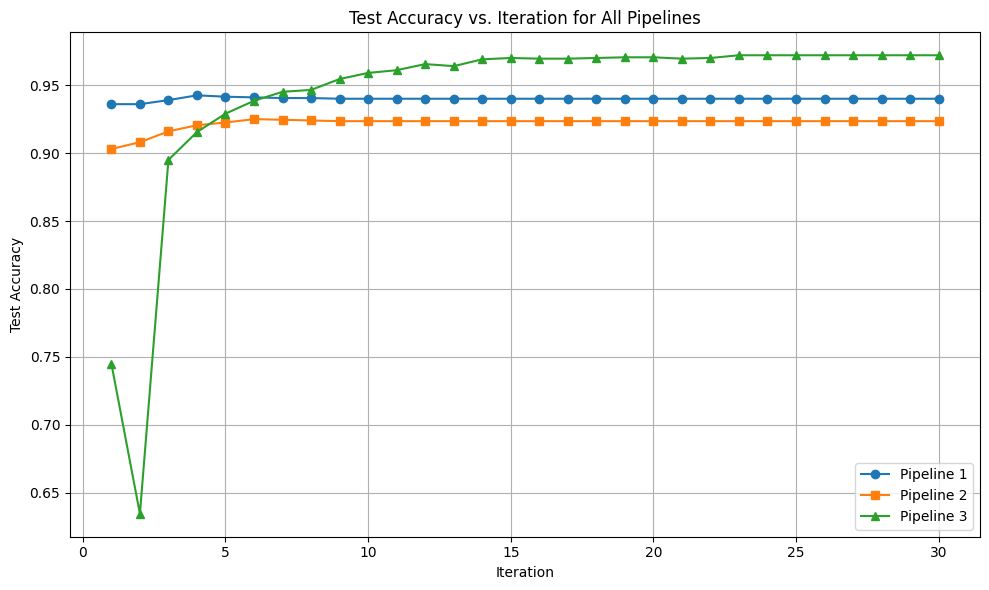

In [1]:
import matplotlib.pyplot as plt

# plotting accuracy values for each pipeline:
pipeline1_acc = [0.9360, 0.9360, 0.9390, 0.9425, 0.9415, 0.9410, 0.9405, 0.9405, 0.9400, 0.9400]
pipeline2_acc = [0.9030, 0.9080, 0.9160, 0.9205, 0.9225, 0.9250, 0.9245, 0.9240, 0.9235]
pipeline3_acc = [0.7450, 0.6345, 0.8950, 0.9155, 0.9290, 0.9385, 0.9451, 0.9465, 0.9545, 0.9590, 
                   0.9610, 0.9655, 0.9640, 0.9690, 0.9700, 0.9695, 0.9695, 0.9700, 0.9705, 0.9705, 
                   0.9695, 0.9700, 0.9720]

def extend_list(acc, total_iterations=30):
    """Extend the accuracy list to total_iterations by repeating the final value."""
    if len(acc) < total_iterations:
        acc_extended = acc + [acc[-1]] * (total_iterations - len(acc))
    else:
        acc_extended = acc[:total_iterations]
    return acc_extended

# Extend each pipeline's accuracy to 30 iterations
pipeline1_acc_extended = extend_list(pipeline1_acc, 30)
pipeline2_acc_extended = extend_list(pipeline2_acc, 30)
pipeline3_acc_extended = extend_list(pipeline3_acc, 30)

# Create iteration numbers 1 to 30
iterations = list(range(1, 31))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(iterations, pipeline1_acc_extended, label='Pipeline 1', marker='o')
plt.plot(iterations, pipeline2_acc_extended, label='Pipeline 2', marker='s')
plt.plot(iterations, pipeline3_acc_extended, label='Pipeline 3', marker='^')
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Iteration for All Pipelines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
